## Minimising the Action of a Discrete Path via Gradient Descent

In [10]:
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt
import action_functions as funcs
from functools import partial

In [11]:
t_a, t_b = [0, 1]
N = 20 # number of time steps
m = 1. # mass
omega = jnp.pi # frequency

t_array = jnp.linspace(t_a, t_b, N)

key = random.PRNGKey(0)

# generate an initial state
x_guess = 0.1 * jnp.sin(jnp.pi * t_array)
#x_guess = random.uniform(key, shape=(N,), minval=-0.1, maxval=0.1)

# boundary conditions
x_guess = x_guess.at[0].set(0.0)
x_guess = x_guess.at[-1].set(0.0)

# defining system
potential = lambda x: funcs.harmonic_potential(x, m=m, omega=omega)
action_fn = lambda x: funcs.action(x, t_a, t_b, N=N, potential=potential)

print(f"Initial action: {action_fn(x_guess)}")

Initial action: -5.616169437416829e-05


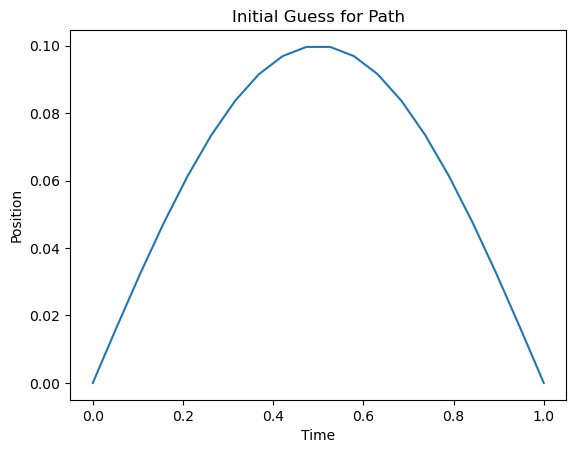

In [12]:
plt.plot(t_array, x_guess)
plt.title('Initial Guess for Path')
plt.xlabel('Time')
plt.ylabel('Position')
plt.show()

In [7]:
# initialising fourier expansion of guess
k = 10 # number of Fourier modes
key, subkey = random.split(key)

# guess coefficients
coeffs = random.uniform(subkey, shape=(k,), minval=-0.1, maxval=0.1)
#coeffs = jnp.array([0.1, 0., 0., 0., 0., 0., 0., 0., 0., 0.]) + random.uniform(key, shape=(k,)) * 0.01

def action_fourier_fn(coeffs):
    return funcs.action_coeff_fn(coeffs, t_a, t_b, m, N, potential)

a_n, action_array, grad_array = funcs.gradient_descent(action_fourier_fn, coeffs, learning_rate=0.001, steps=1000)
# x, action_array, grad_array = funcs.gradient_descent(action_fn, x_guess, learning_rate=0.01, steps=10000)

Step 0, action: 1.946464, grad_norm: 24.124033
Step 100, action: -0.117805, grad_norm: 4.412993
Step 200, action: -0.455064, grad_norm: 2.590154
Step 300, action: -0.928649, grad_norm: 3.687411
Step 400, action: -1.594038, grad_norm: 4.831018
Step 500, action: -2.449327, grad_norm: 5.988383
Step 600, action: -3.489487, grad_norm: 7.147679
Step 700, action: -4.708528, grad_norm: 8.302821
Step 800, action: -6.100314, grad_norm: 9.450582
Step 900, action: -7.658851, grad_norm: 10.589214
Did not converge within the specified number of steps.


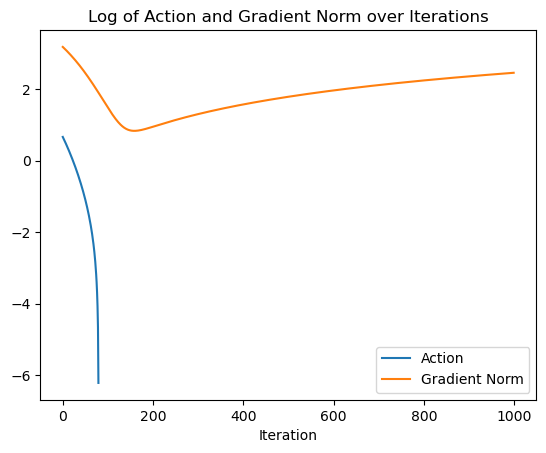

In [8]:
iter_array = jnp.arange(len(action_array))

plt.plot(iter_array, jnp.log(action_array), label='Action')
plt.plot(iter_array, jnp.log(grad_array), label='Gradient Norm')
plt.title('Log of Action and Gradient Norm over Iterations')
plt.xlabel('Iteration')
plt.legend(loc='best')
plt.show()

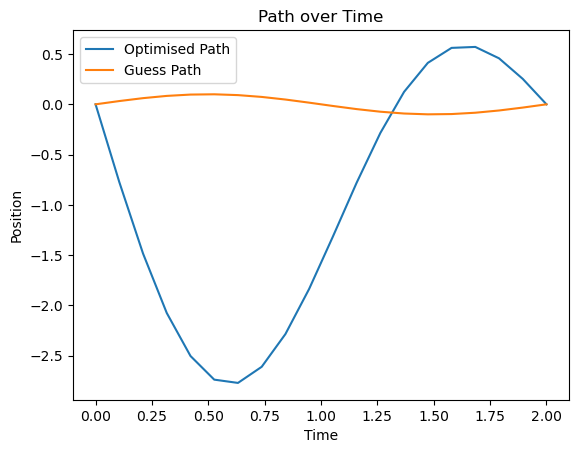

In [9]:
# plt.plot(t_array, x, label='Optimised Path')
plt.plot(t_array, funcs.fourier_basis_expansion(t_array,a_n), label='Optimised Path')
plt.plot(t_array, x_guess, label='Guess Path')
plt.title('Path over Time')
plt.xlabel('Time')
plt.ylabel('Position')
plt.legend(loc='best')
plt.show()